Load MNIST data.
Original data shape (N, D): (60000, 784)
Preprocessing data begins.
Standardized data shape: (60000, 784)
Performing PCA.
Covariance matrix shape: (784, 784)
Eigenvectors shape: (784, 784)
Eigenvalues shape: (784,)
Plotting top 5 principal components.


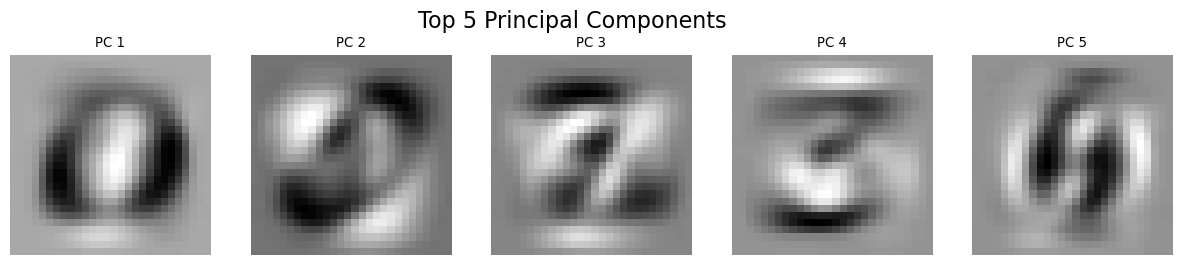

In [26]:
import numpy as np
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

# Data load: MNIST train data load (60,000 samples)
print("Load MNIST data.")
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

# Transform data into (N, D) shape: N = 60000 (Number of samples), D = 784 (dimension, 28*28)
N = mnist_trainset.data.shape[0]
D = mnist_trainset.data.shape[1] * mnist_trainset.data.shape[2]
X = mnist_trainset.data.numpy().reshape(N, D)

# Type transform into float for calculation 
X = X.astype(np.float64)
print(f"Original data shape (N, D): {X.shape}") # (60000, 784)

# Preprocessing 
print("Preprocessing data begins.")

# Centering: Calculate mean of each dimension (axis=0)
mean = np.mean(X, axis=0)

# Standardization: Calculate standard deviation of each dimension 
epsilon = 1e-10 
std = np.std(X, axis=0) 
std[std == 0] = 1.0 # To prevent 0 divide

# Standardization: X_std = (X - mean) / std
X_std = (X - mean) / std
print(f"Standardized data shape: {X_std.shape}")

# PCA 
print("Performing PCA.")

# Calculate covariance matrix
C = np.cov(X_std, rowvar=False) # Shape of C: (D,D) = (784,784)

# Eigen Decomposition
eigenvalues, eigenvectors = np.linalg.eigh(C)

print(f"Covariance matrix shape: {C.shape}")
print(f"Eigenvectors shape: {eigenvectors.shape}")
print(f"Eigenvalues shape: {eigenvalues.shape}")

# Plotting the best 5 components 
print("Plotting top 5 principal components.")

# Since eigh returns the eigenvalues in ascending order, 
# sort the indices in descending order to find the largest eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]

# Reorder using ordered index: each column of eigenvectors represents b_i
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# M=5, Select top 5 eigenvectors
M = 5
top_5_pcs = sorted_eigenvectors[:, :M] # Shape: (784, 5)

# Print images
fig, axes = plt.subplots(1, M, figsize=(15, 3))

for i in range(M):
    # Reshape (784,)into (28, 28) 
    pc_image = top_5_pcs[:, i].reshape(28, 28)
    
    ax = axes[i]
    ax.imshow(pc_image, cmap='gray')
    ax.set_title(f"PC {i+1}")
    ax.axis('off')

plt.suptitle("Top 5 Principal Components", fontsize=16)
plt.show()

In [27]:
# Select specific sample for reconstruction
sample_index = 0
x_n_original = X[sample_index] # 원본 이미지 (시각화용)
x_n_std = X_std[sample_index]    # 표준화된 이미지 (계산용)

# B matrix (D x M) = (784, 5)
B = top_5_pcs

# Problem 1.2 (a)
# z_n = B^T * x_n 
z_n = B.T @ x_n_std  # (5, 784) @ (784,) = (5,)
print(f"Problem 1.2 (a): Latent variable z_n (shape {z_n.shape})")
print(z_n)

Problem 1.2 (a): Latent variable z_n (shape (5,))
[ 0.92215881 -4.81479035 -0.06755984 -8.0513293  -0.9853473 ]


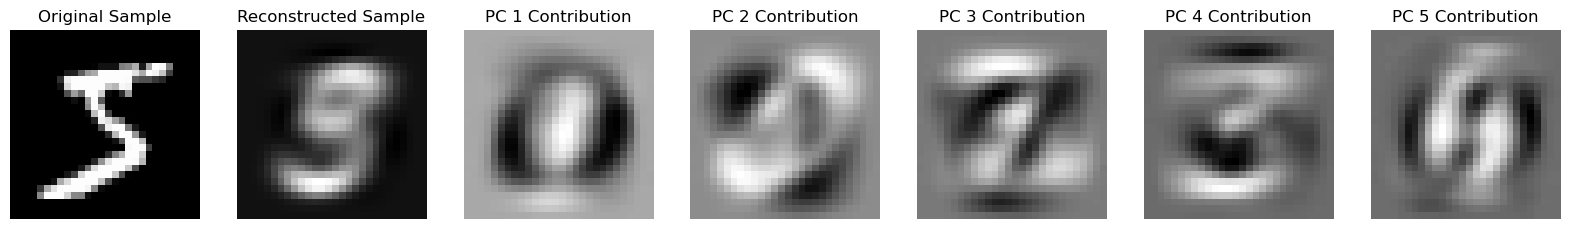

In [28]:
# Problem 1.2 (b)

# Image reconstruction
# x_n_tilde = B * z_n
x_n_tilde_std = B @ z_n # (784, 5) @ (5,) = (784,)

# Undo the standardization of reconstruction image 
# x_n_reconstructed = (x_n_tilde_std * std) + mean
x_n_reconstructed = (x_n_tilde_std * std) + mean # 'mean' and 'std' from 1.1

# Calculate (z_mn * b_m)
pc_contributions = []
for i in range(M):
    contribution = z_n[i] * B[:, i] # z_n[i]: scalar, B[:, i]: m-th vector
    pc_contributions.append(contribution)

# Print images
fig, axes = plt.subplots(1, 2 + M, figsize=(20, 4))
plt.rcParams.update({'font.size': 10})

# Plot 1: Original Sample
axes[0].imshow(x_n_original.reshape(28, 28), cmap='gray')
axes[0].set_title("Original Sample")
axes[0].axis('off')

# Plot 2: Reconstructed Sample
axes[1].imshow(x_n_reconstructed.reshape(28, 28), cmap='gray')
axes[1].set_title("Reconstructed Sample")
axes[1].axis('off')

# Plots 3~7: PC Contributions
for i in range(M):
    ax = axes[i + 2]
    ax.imshow(pc_contributions[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"PC {i+1} Contribution")
    ax.axis('off')
        
plt.show()

In [29]:
# Problem 1.2 (c)

# 오류 J_M은 표준화된(standardized) 공간에서 정의됩니다.
# Calculate difference between (original x_n) and (reconstructed x_n_tilde)

# x_n_std : standardized original sample ((784,)) used in (b)
# x_n_tilde_std : reconstructed sample ((784,)) calculated in (b)
error_single_sample = np.sum((x_n_std - x_n_tilde_std)**2)
print(f"Reconstruction error of the single sample: {error_single_sample:.4f}")

Reconstruction error of the single sample: 867.6358


In [30]:
# Problem 1.2 (d)

# Projection
# Z = X_std @ B: (60000, 784) @ (784, 5) = (60000, 5)
Z_all = X_std @ B

# Reconstruct 784 dim from Z_all 
# X_tilde_std = Z_all @ B.T: (60000, 5) @ (5, 784) = (60000, 784)
X_tilde_std_all = Z_all @ B.T

# Calculate L2 norm 
# (X_std - X_tilde_std_all): (60000, 784)
errors_per_sample = np.sum((X_std - X_tilde_std_all)**2, axis=1)

# Calculate mean error of all samples 
# J_5 = (1/N) * sum(errors_per_sample)
J_5 = np.mean(errors_per_sample)

print(f"Mean reconstruction error (J_5) over all samples: {J_5:.4f}")

# (참고) 이론적인 오류 값 (사용하지 않은 고유값들의 합)
# 1.1에서 계산한 'eigenvalues'와 'sorted_indices'가 필요합니다.
# sorted_eigenvalues = eigenvalues[sorted_indices]
# M = 5
# remaining_eigenvalues = sorted_eigenvalues[M:]
# 
# # np.cov는 (N-1)로 나누므로, J_5 (1/N) 공식과 맞추기 위해 (N-1)/N을 곱해줌
# theoretical_J_5 = np.sum(remaining_eigenvalues) * (N-1)/N
# print(f"Theoretical error (sum of dropped eigenvalues): {theoretical_J_5:.4f}")
# (위 값은 J_5 값과 거의 동일해야 합니다)

Mean reconstruction error (J_5) over all samples: 581.6978


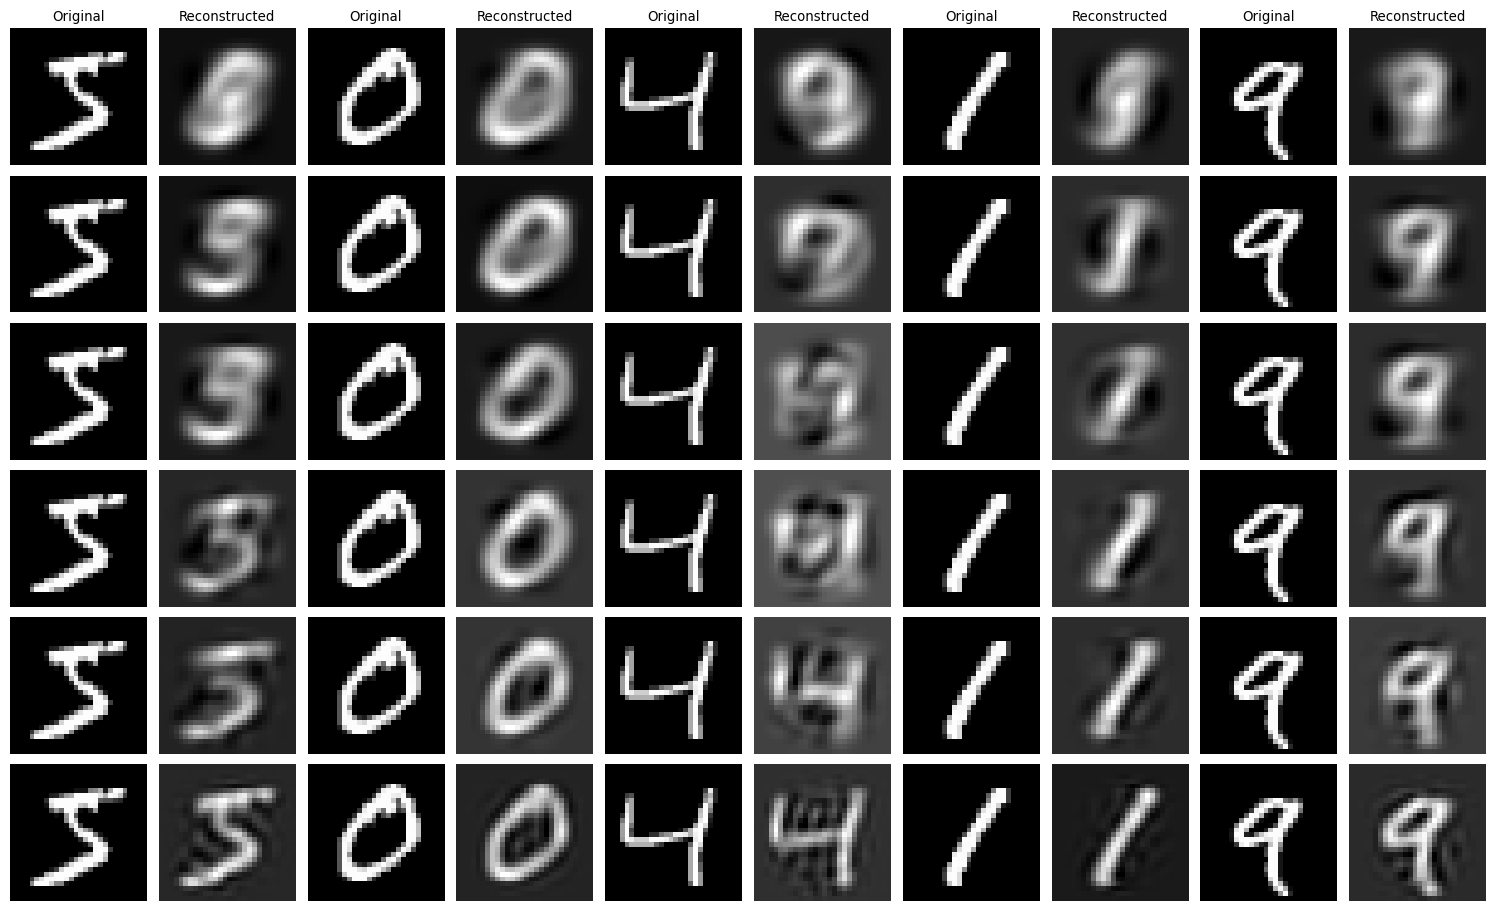

In [31]:
import time

# Problem 1.3 (a)
# M list
M_list = [2, 5, 10, 20, 50, 200]

# Sample index
sample_indices = [0, 1, 2, 3, 4]
num_samples = len(sample_indices) # 5

# Plotting
fig, axes = plt.subplots(len(M_list), num_samples * 2, figsize=(15, 10))
plt.rcParams.update({'font.size': 8}) 

for i, M in enumerate(M_list):
    # Select M-th top eigenvectors 
    B_M = sorted_eigenvectors[:, :M] # (D, M) = (784, M)
    
    for j, sample_idx in enumerate(sample_indices):
        # Original smaples
        x_n_original = X[sample_idx]    
        x_n_std = X_std[sample_idx]
        
        # Projection
        z_n = B_M.T @ x_n_std # (M, 784) @ (784,) = (M,)
        
        # Reconstruction
        x_n_tilde_std = B_M @ z_n # (784, M) @ (M,) = (784,)
        
        # Un-standardize
        x_n_reconstructed = (x_n_tilde_std * std) + mean
        
        # Plot
        ax_orig = axes[i, j*2]
        ax_orig.imshow(x_n_original.reshape(28, 28), cmap='gray')
        ax_orig.axis('off')
        if j == 0: # Label of M 
            ax_orig.set_ylabel(f"M={M}", fontsize=12)
        if i == 0: # Label of top 
            ax_orig.set_title("Original")
        
        ax_recon = axes[i, j*2 + 1]
        ax_recon.imshow(x_n_reconstructed.reshape(28, 28), cmap='gray')
        ax_recon.axis('off')
        if i == 0: # Label of top
            ax_recon.set_title("Reconstructed")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Problem 1.3 (b)
  M=2, J_M=647.2718 (Processing time: 0.40s)
  M=5, J_M=581.6978 (Processing time: 0.42s)
  M=10, J_M=518.6002 (Processing time: 0.43s)
  M=20, J_M=444.0760 (Processing time: 0.42s)
  M=50, J_M=321.8944 (Processing time: 0.50s)
  M=200, J_M=95.0774 (Processing time: 0.70s)


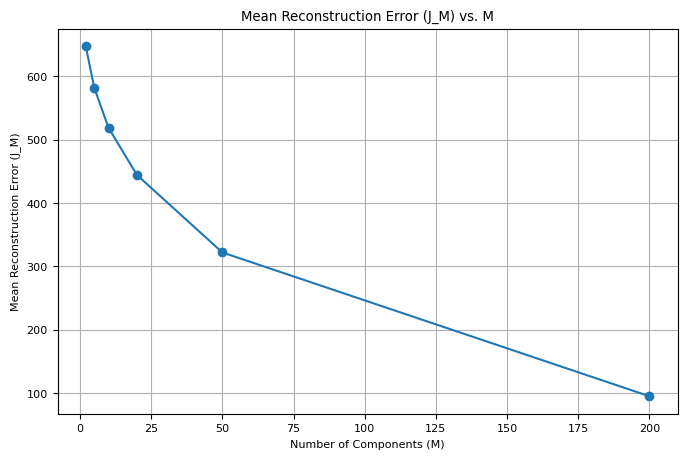

M =   2, J_M = 647.2718
M =   5, J_M = 581.6978
M =  10, J_M = 518.6002
M =  20, J_M = 444.0760
M =  50, J_M = 321.8944
M = 200, J_M = 95.0774


In [32]:
# Problem 1.3 (b)
print("Problem 1.3 (b)")

J_M_list = []
# eigenvalues calculated at 1.1 (ordered)
sorted_eigenvalues = eigenvalues[sorted_indices]

start_time = time.time()
for M in M_list:
    B_M = sorted_eigenvectors[:, :M]
    Z_all = X_std @ B_M
    X_tilde_std_all = Z_all @ B_M.T
    errors_per_sample = np.sum((X_std - X_tilde_std_all)**2, axis=1)
    J_M = np.mean(errors_per_sample)
    J_M_list.append(J_M)
    print(f"  M={M}, J_M={J_M:.4f} (Processing time: {time.time() - start_time:.2f}s)")
    start_time = time.time()

# Plotting J_M
plt.figure(figsize=(8, 5))
plt.plot(M_list, J_M_list, 'o-') 
plt.title("Mean Reconstruction Error (J_M) vs. M")
plt.xlabel("Number of Components (M)")
plt.ylabel("Mean Reconstruction Error (J_M)")
plt.grid(True)
plt.show()

for M, J_M in zip(M_list, J_M_list):
    print(f"M = {M:3d}, J_M = {J_M:.4f}")

Test data shape (N_test, D): (10000, 784)


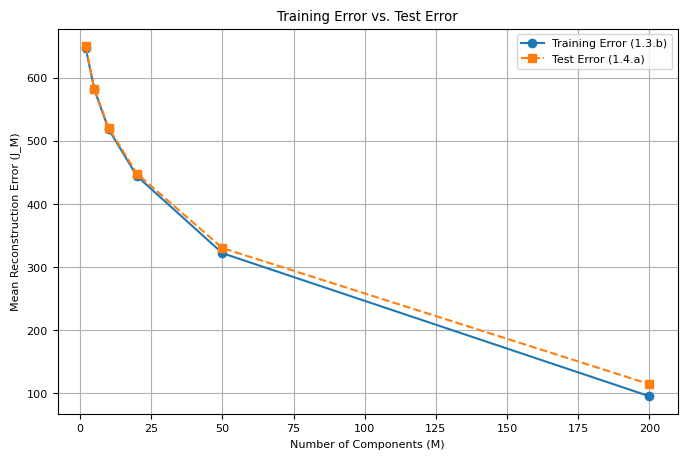

In [ ]:
# Problem 1.4
# Load test data
J_M_list_train = J_M_list 
# MNIST test data (10,000 samples)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Reshape data into (N_test, D)
N_test = mnist_testset.data.shape[0] # 10000
X_test = mnist_testset.data.numpy().reshape(N_test, D) # D = 784

# Type transform into float
X_test = X_test.astype(np.float64)

print(f"Test data shape (N_test, D): {X_test.shape}") # (10000, 784)

# Preprocessing of test data 
X_test_std = (X_test - mean) / std

# Calculate J_M
J_M_list_test = [] 

for M in M_list:
    # B_M
    B_M = sorted_eigenvectors[:, :M]
    
    # Projection
    Z_test_all = X_test_std @ B_M # (10000, 784) @ (784, M) = (10000, M)
    
    # Reconstruction
    X_tilde_test_std_all = Z_test_all @ B_M.T # (10000, M) @ (M, 784) = (10000, 784)
    
    # L2 norm 
    errors_per_sample_test = np.sum((X_test_std - X_tilde_test_std_all)**2, axis=1)
    J_M_test = np.mean(errors_per_sample_test)
    J_M_list_test.append(J_M_test)
    
# Plot for training error vs. test error
plt.figure(figsize=(8, 5))
plt.plot(M_list, J_M_list_train, 'o-', label='Training Error (1.3.b)')
plt.plot(M_list, J_M_list_test, 's--', label='Test Error (1.4.a)')
plt.title("Training Error vs. Test Error")
plt.xlabel("Number of Components (M)")
plt.ylabel("Mean Reconstruction Error (J_M)")
plt.legend()
plt.grid(True)
plt.show()

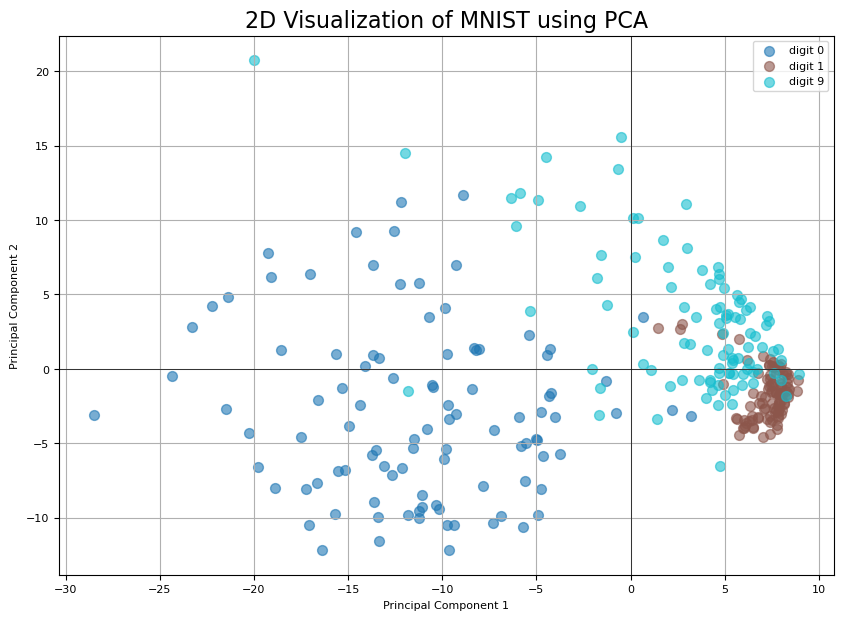

In [ ]:
# Problem 1.5
# Matrix for M=2 
M_2 = 2
B_2 = sorted_eigenvectors[:, :M_2] # Shape (D, M) = (784, 2)

# Get label 
labels = mnist_trainset.targets.numpy() # Shape (60000,)

# Select 100 samples and 2D projection 
target_classes = [0, 1, 9]
colors = ['tab:blue', 'tab:brown', 'tab:cyan'] 
num_to_select = 100

plt.figure(figsize=(10, 7))
for target_class, color in zip(target_classes, colors):
    # Find index for each class 
    class_indices = np.where(labels == target_class)[0]
    
    # Select 100 samples from index 
    selected_indices = np.random.choice(class_indices, num_to_select, replace=False)
    
    # Get data from selected index 
    X_selected = X_std[selected_indices] # Shape (100, 784)
    
    # Projection, Z = X @ B: (100, 784) @ (784, 2) = (100, 2)
    Z_selected = X_selected @ B_2
    
    # Plotting
    # Z_selected[:, 0] : Principal Component 1, Z_selected[:, 1] : Principal Component 2
    plt.scatter(Z_selected[:, 0], Z_selected[:, 1], 
                c=color, label=f'digit {target_class}', 
                alpha=0.6, s=50) 

# 4. Plotting
plt.title("2D Visualization of MNIST using PCA", fontsize=16)
plt.xlabel("Principal Component 1"); plt.ylabel("Principal Component 2")
plt.legend(); plt.grid(True); 
plt.axhline(0, color='black', linewidth=0.5); plt.axvline(0, color='black', linewidth=0.5)
plt.show()

Autoencoder model (M=2) created.
Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Epoch [1/20], Train J_M: 0.078068, Test J_M: 0.063402
Epoch [2/20], Train J_M: 0.062226, Test J_M: 0.061608
Epoch [3/20], Train J_M: 0.061311, Test J_M: 0.061168
Epoch [4/20], Train J_M: 0.060930, Test J_M: 0.060768
Epoch [5/20], Train J_M: 0.060542, Test J_M: 0.060343
Epoch [6/20], Train J_M: 0.060120, Test J_M: 0.059874
Epoch [7/20], Train J_M: 0.059702, Test J_M: 0.059432
Epoch [8/20], Train J_M: 0.059330, Test J_M: 0.059138
Epoch [9/20], Train J_M: 0.059032, Test J_M: 0.058930
Epoch [10/20], Train J_M: 0.058803, Test J_M: 0.058689
Epoch [11/20], Train J_M: 0.058522, Test J

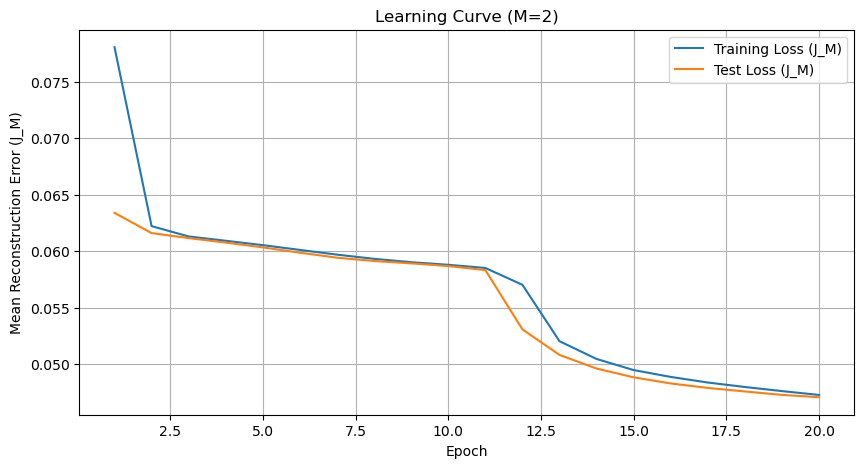

In [3]:
import torch; import torch.nn as nn; import torch.optim as optim
import torchvision.transforms as transforms; import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Settings for hyperparameter 
epochs = 20; learning_rate = 0.001; size_batch = 256; M = 2 

# Dimensions
D_in = 784 # 28 * 28
H = 128    # hidden layer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data load and preprocessing 
# Sigmoid setting
transform = transforms.Compose([transforms.ToTensor()]) # (0-255) -> (0.0-1.0)

# Training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=size_batch, shuffle=True)

# Test data
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=size_batch, shuffle=False)

# Model generation
class Autoencoder(nn.Module):
    def __init__(self, D_in, H, M):
        super(Autoencoder, self).__init__()
        
        # Encoder (D -> H -> M)
        self.encoder = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Linear(H, M),
            nn.ReLU() 
        )
        
        # Decoder (M -> H -> D)
        self.decoder = nn.Sequential(
            nn.Linear(M, H),
            nn.ReLU(),
            nn.Linear(H, D_in),
            nn.Sigmoid() 
        )

    def forward(self, x):
        # Transform into 784 dim vector 
        x_flat = x.view(x.size(0), -1) 
        
        z = self.encoder(x_flat)
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed


# Model # Loss function, J_M: Mean Squared Error (MSE) # Optimizer: Adam
model = Autoencoder(D_in, H, M).to(device); criterion = nn.MSELoss(); optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Autoencoder model (M={M}) created.")
print(model)

# Training 
train_losses = []; test_losses = []

for epoch in range(epochs):
    # Training
    model.train() 
    running_train_loss = 0.0
    
    for images, _ in train_loader: 
        images = images.to(device)
        
        # Flattening 
        images_flat = images.view(images.size(0), -1)
        
        # Injection data into model
        reconstructed = model(images_flat)
        
        # Calculate loss
        loss = criterion(reconstructed, images_flat)
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() * images.size(0)
    
    # Mean loss 
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Test
    model.eval(); running_test_loss = 0.0
    
    with torch.no_grad(): 
        for images, _ in test_loader:
            images = images.to(device)
            images_flat = images.view(images.size(0), -1)
            
            reconstructed = model(images_flat)
            
            loss = criterion(reconstructed, images_flat)
            running_test_loss += loss.item() * images.size(0)

    # Mean loss 
    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    
    print(f"Epoch [{epoch+1}/{epochs}], Train J_M: {epoch_train_loss:.6f}, Test J_M: {epoch_test_loss:.6f}")

# Curve plotting 
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss (J_M)')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss (J_M)')
plt.title(f'Learning Curve (M={M})')
plt.xlabel('Epoch'); plt.ylabel('Mean Reconstruction Error (J_M)')
plt.legend(); plt.grid(True); plt.show()

PCA Eigendecomposition complete.
PCA J_M (M=2): 0.055669
PCA J_M (M=5): 0.044526
PCA J_M (M=10): 0.034074

Training Autoencoder with M=2...
Epoch [20/20], Final Test J_M: 0.045346

Training Autoencoder with M=5...
Epoch [20/20], Final Test J_M: 0.039877

Training Autoencoder with M=10...
Epoch [20/20], Final Test J_M: 0.021801


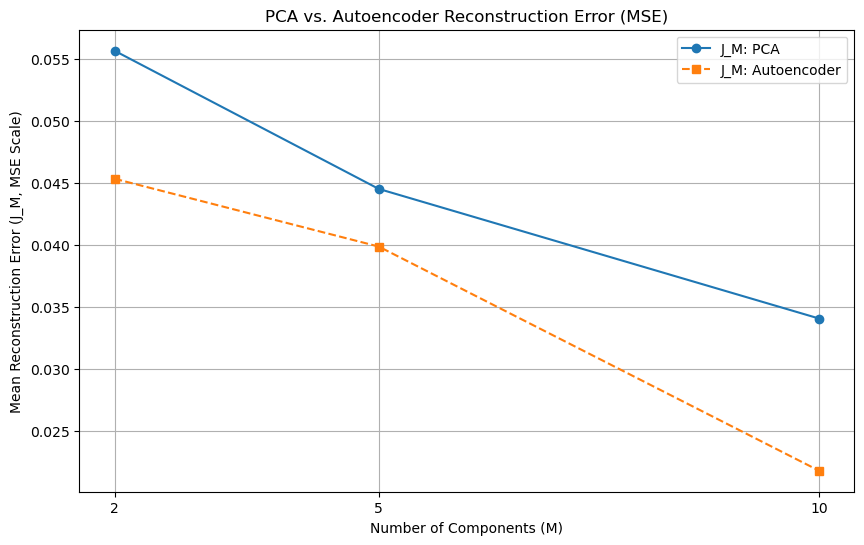

In [5]:
import torch; import torch.nn as nn; import torch.optim as optim
import torchvision.transforms as transforms; import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np; import time

# Settings
M_list = [2, 5, 10]; epochs = 20; learning_rate = 0.001; size_batch = 256
D_in = 784; H = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {
    'M': M_list,
    'J_M_pca': [],
    'J_M_ae': []
}

# J_M of PCA 
# Data load
mnist_train_np = datasets.MNIST(root='./data', train=True, download=True)
N = mnist_train_np.data.shape[0]
X_train_norm = mnist_train_np.data.numpy().reshape(N, D_in).astype(np.float64) / 255.0

mnist_test_np = datasets.MNIST(root='./data', train=False, download=True)
N_test = mnist_test_np.data.shape[0]
X_test_norm = mnist_test_np.data.numpy().reshape(N_test, D_in).astype(np.float64) / 255.0

mean_vec = np.mean(X_train_norm, axis=0)
X_train_centered = X_train_norm - mean_vec
X_test_centered = X_test_norm - mean_vec

# Covariance matrix and eigenvalues 
C = np.cov(X_train_centered, rowvar=False)
eigenvalues, eigenvectors = np.linalg.eigh(C)
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
print("PCA Eigendecomposition complete.")

# Calculate J_M
for M in M_list:
    B_M = sorted_eigenvectors[:, :M] # (784, M)
    
    # Projection
    Z_test = X_test_centered @ B_M # (N_test, 784) @ (784, M) = (N_test, M)
    
    # Reconstruction
    X_tilde_test_centered = Z_test @ B_M.T # (N_test, M) @ (M, 784) = (N_test, 784)
    
    errors_per_sample = np.sum((X_test_centered - X_tilde_test_centered)**2, axis=1)
    J_M_pca_mse = np.mean(errors_per_sample) / D_in 

    results['J_M_pca'].append(J_M_pca_mse)
    print(f"PCA J_M (M={M}): {J_M_pca_mse:.6f}")

# Autoencoder, J_M 
# Data load 
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=size_batch, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=size_batch, shuffle=False)

# Model 
class Autoencoder(nn.Module):
    def __init__(self, D_in, H, M):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(D_in, H), nn.ReLU(),
            nn.Linear(H, M), nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(M, H), nn.ReLU(),
            nn.Linear(H, D_in), nn.Sigmoid()
        )
    def forward(self, x):
        x_flat = x.view(x.size(0), -1) 
        z = self.encoder(x_flat)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

# Comparison: M=2, 5, 10
for M in M_list:
    print(f"\nTraining Autoencoder with M={M}...")
    model_ae = Autoencoder(D_in, H, M).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_ae.parameters(), lr=learning_rate)
    
    final_test_loss = 0.0
    
    for epoch in range(epochs):
        # Training
        model_ae.train()
        for images, _ in train_loader:
            images = images.to(device)
            images_flat = images.view(images.size(0), -1)
            reconstructed = model_ae(images_flat)
            loss = criterion(reconstructed, images_flat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Loss calculation at last epoch 
        if epoch == epochs - 1:
            model_ae.eval()
            running_test_loss = 0.0
            with torch.no_grad():
                for images, _ in test_loader:
                    images = images.to(device)
                    images_flat = images.view(images.size(0), -1)
                    reconstructed = model_ae(images_flat)
                    loss = criterion(reconstructed, images_flat)
                    running_test_loss += loss.item() * images.size(0)
            
            final_test_loss = running_test_loss / len(test_loader.dataset)
            results['J_M_ae'].append(final_test_loss)
            print(f"Epoch [{epoch+1}/{epochs}], Final Test J_M: {final_test_loss:.6f}")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results['M'], results['J_M_pca'], 'o-', label=f'J_M: PCA')
plt.plot(results['M'], results['J_M_ae'], 's--', label=f'J_M: Autoencoder')
plt.title('PCA vs. Autoencoder Reconstruction Error (MSE)')
plt.xlabel('Number of Components (M)'); plt.ylabel('Mean Reconstruction Error (J_M, MSE Scale)')
plt.xticks(M_list); plt.legend(); plt.grid(True); plt.show()

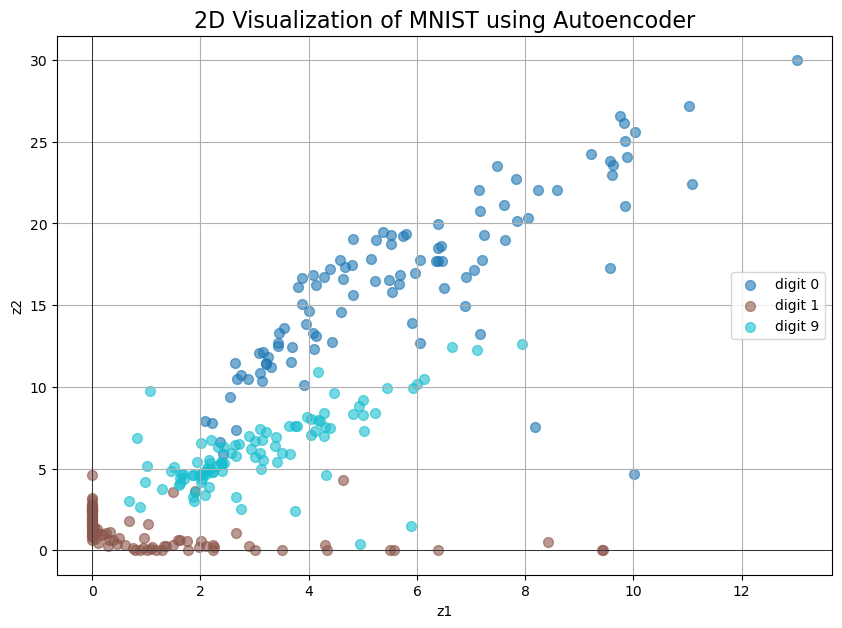

In [8]:
# 2.2(a)
# Data load
labels = train_dataset.targets.numpy() # (60000,)
images_data = train_dataset.data       # (60000, 28, 28), [0, 255] uint8

# Select 100 samples and projection 
target_classes = [0, 1, 9]; colors = ['tab:blue', 'tab:brown', 'tab:cyan']; num_to_select = 100

plt.figure(figsize=(10, 7))
model.eval() 

with torch.no_grad(): 
    for target_class, color in zip(target_classes, colors):
        # Find index 
        class_indices = np.where(labels == target_class)[0]
        
        # Select 100 samples (100, 28, 28)
        selected_indices = np.random.choice(class_indices, num_to_select, replace=False)
        X_selected_data = images_data[selected_indices]
        
        # Preprocessing: (uint8 [0, 255]) -> (float32 [0.0, 1.0])
        X_selected_tensor = X_selected_data.float() / 255.0
        
        # Flattening: 784dim vector
        X_selected_flat = X_selected_tensor.view(-1, D_in).to(device)
        
        # Injection into model: (N, 784) -> (N, 2)
        z_n = model.encoder(X_selected_flat)
        z_n_cpu = z_n.cpu().numpy()
        
        # Plot (scatter)
        plt.scatter(z_n_cpu[:, 0], z_n_cpu[:, 1], c=color, label=f'digit {target_class}', alpha=0.6, s=50)

# Plotting
plt.title("2D Visualization of MNIST using Autoencoder", fontsize=16)
plt.xlabel("z1"); plt.ylabel("z2")
plt.legend(); plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5); plt.axvline(0, color='black', linewidth=0.5)
plt.show()

Using device: cpu
VAE model (M=2) created.
VAE(
  (encoder_shared): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=128, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)
Starting training for 20 epochs...
Epoch [1/20], Train Loss: 62.4764, Test Loss: 49.1072
Epoch [2/20], Train Loss: 47.3546, Test Loss: 45.7603
Epoch [3/20], Train Loss: 44.9689, Test Loss: 44.0637
Epoch [4/20], Train Loss: 43.8552, Test Loss: 43.3011
Epoch [5/20], Train Loss: 43.1290, Test Loss: 42.6194
Epoch [6/20], Train Loss: 42.5758, Test Loss: 42.1730
Epoch [7/20], Train Loss: 42.1097, Test Loss: 41.7660
Epoch [8/20], Train Loss: 41.6948, Test Loss: 41.3896
Epoch [9/20], Train Loss: 41.3558, Test Loss: 41.1193


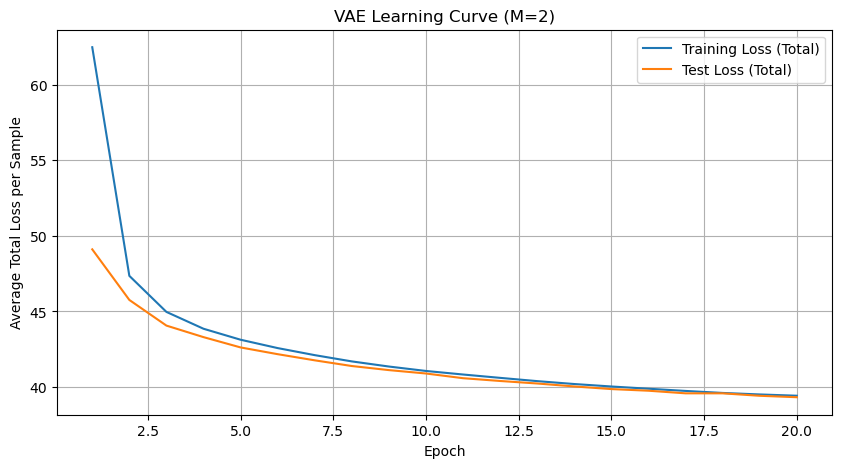

In [ ]:
import torch; import torch.nn as nn; import torch.nn.functional as F; import torch.optim as optim
import torchvision.transforms as transforms; import torchvision.datasets as datasets
from torch.utils.data import DataLoader; import matplotlib.pyplot as plt; import numpy as np

# Set hyperparameters
epochs = 20; learning_rate = 0.001; size_batch = 256; M = 2 

# Dimensions
D_in = 784 # 28 * 28
H = 128    # hidden layer

# Data load and preprocessing 
# Normalization: [0, 1] 
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=size_batch, shuffle=True)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(dataset=test_dataset, batch_size=size_batch, shuffle=False)

# Model
class VAE(nn.Module):
    def __init__(self, D_in, H, M):
        super(VAE, self).__init__()
        
        # Encoder (D -> H)
        self.encoder_shared = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU()
        )
        
        # M(mu) and M(log_var)
        self.fc_mu = nn.Linear(H, M)      # Mean
        self.fc_log_var = nn.Linear(H, M) # Log-Variance
        
        # Decoder (M -> H -> D)
        self.decoder = nn.Sequential(
            nn.Linear(M, H),
            nn.ReLU(),
            nn.Linear(H, D_in),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        """Reparameterization Trick: z = mu + std * epsilon"""
        std = torch.exp(0.5 * log_var)  # std = sigma
        epsilon = torch.randn_like(std) # epsilon ~ N(0, 1)
        return mu + (std * epsilon)

    def forward(self, x):
        # Transform into 784 dim vector 
        x_flat = x.view(x.size(0), -1) 
        
        # Encoder
        h_enc = self.encoder_shared(x_flat)
        mu = self.fc_mu(h_enc)
        log_var = self.fc_log_var(h_enc)
        
        # Reparameterization
        z = self.reparameterize(mu, log_var)
        
        # Decoder
        x_reconstructed = self.decoder(z)
        
        return x_reconstructed, mu, log_var

# Model, Loss function, Optimizer
model = VAE(D_in, H, M).to(device); optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training 
train_losses = []; test_losses = []

for epoch in range(epochs):
    # Training
    model.train()
    running_train_loss = 0.0
    
    for images, _ in train_loader:
        images = images.to(device)
        images_flat = images.view(images.size(0), -1)
        
        # Injection to model
        reconstructed, mu, log_var = model(images_flat)
        
        # Reconstruction Loss (J_M: MSE)
        recon_loss = F.mse_loss(reconstructed, images_flat, reduction='sum')
        
        # KL Divergence Loss
        kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Total Loss = Reconstruction + KLD
        loss = recon_loss + kld_loss
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item() # Total loss
    
    # Mean loss 
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # Test
    model.eval()
    running_test_loss = 0.0
    
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            images_flat = images.view(images.size(0), -1)
            
            reconstructed, mu, log_var = model(images_flat)
            
            recon_loss = F.mse_loss(reconstructed, images_flat, reduction='sum')
            kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = recon_loss + kld_loss
            
            running_test_loss += loss.item()

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)
    
    print(
    f"Epoch [{epoch+1}/{epochs}], "
    f"Train Loss: {epoch_train_loss:.4f}, "
    f"Test Loss: {epoch_test_loss:.4f}"
)

print("Training finished.")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), train_losses, label='Training Loss (Total)')
plt.plot(range(1, epochs+1), test_losses, label='Test Loss (Total)')
plt.title(f'VAE Learning Curve (M={M})')
plt.xlabel('Epoch'); plt.ylabel('Average Total Loss per Sample')
plt.legend(); plt.grid(True); plt.show()

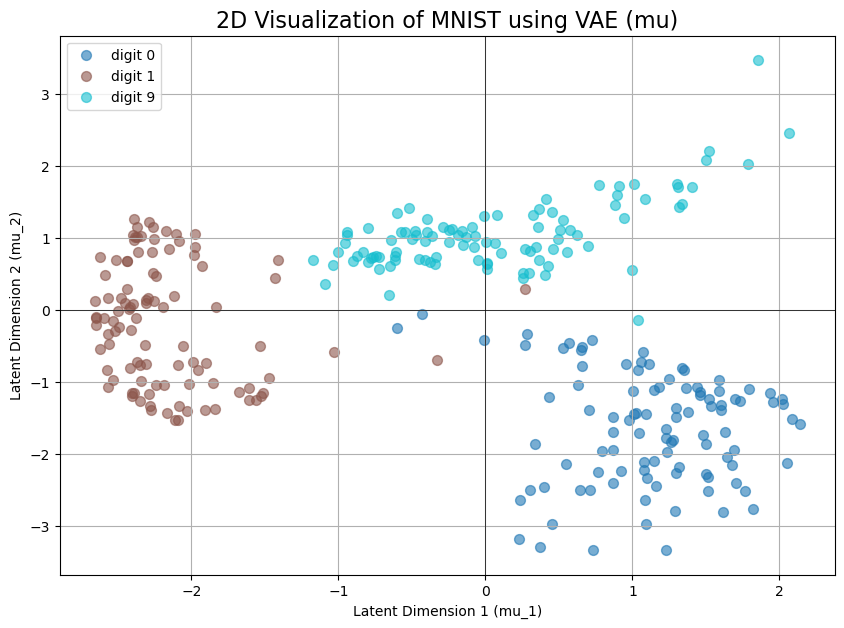

In [10]:
# 3.2(a)
# Load data
labels = train_dataset.targets.numpy() # (60000,)
images_data = train_dataset.data       # (60000, 28, 28), [0, 255] uint8

# Select 100 samples and projection 
target_classes = [0, 1, 9]
colors = ['tab:blue', 'tab:brown', 'tab:cyan'] 
num_to_select = 100

plt.figure(figsize=(10, 7))
model.eval() 

with torch.no_grad(): 
    for target_class, color in zip(target_classes, colors):
        # Find index 
        class_indices = np.where(labels == target_class)[0]
        
        # Select 100 samples
        selected_indices = np.random.choice(class_indices, num_to_select, replace=False)
        X_selected_data = images_data[selected_indices]
        
        # Preprocessing
        X_selected_tensor = X_selected_data.float() / 255.0
        
        # Flattening: 784 dim vector
        X_selected_flat = X_selected_tensor.view(-1, D_in).to(device)

        # Injection to model 
        h_enc = model.encoder_shared(X_selected_flat)
        mu = model.fc_mu(h_enc) # 이것이 바로 mu_n = mu_phi(x_n)
        
        mu_cpu = mu.cpu().numpy()
        
        # Plotting
        plt.scatter(mu_cpu[:, 0], mu_cpu[:, 1], 
                    c=color, label=f'digit {target_class}', 
                    alpha=0.6, s=50)

# Plotting
plt.title("2D Visualization of MNIST using VAE (mu)", fontsize=16)
plt.xlabel("Latent Dimension 1 (mu_1)"); plt.ylabel("Latent Dimension 2 (mu_2)")
plt.legend(); plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5); plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [ ]:
class MyInt:                   
    def __init__(self, value):   
        self.v = value         
                               
    def add(self, a):
        self.v = self.v + a